<a href="https://colab.research.google.com/github/rafiqmyura/Learn-Machine-Learning/blob/main/Flower_Detection_Type_(CNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image


# import data handling tools

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# import Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Warning Notification

import warnings
warnings.filterwarnings("ignore")

print('modules loaded')

modules loaded


## Data Preprocessing

**Read DataFrame and Store**

In [3]:
data_dir= '/content/drive/MyDrive/frayer data/flower_images'
filepath = []
labels = []

folds = os.listdir(data_dir)
for fold in folds :
  foldpath = os.path.join(data_dir, fold)
  filelist = os.listdir(foldpath)
  for file in filelist:
    fpath = os.path.join(foldpath, file)
    filepath.append(fpath)
    labels.append(fold)


Fseries = pd.Series(filepath, name= 'filepath')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)

In [4]:
df

,filepath,labels
0,/content/drive/MyDrive/frayer data/flower_imag...,Lilly
1,/content/drive/MyDrive/frayer data/flower_imag...,Lilly
2,/content/drive/MyDrive/frayer data/flower_imag...,Lilly
3,/content/drive/MyDrive/frayer data/flower_imag...,Lilly
4,/content/drive/MyDrive/frayer data/flower_imag...,Lilly
...,...,...
4995,/content/drive/MyDrive/frayer data/flower_imag...,Tulip
4996,/content/drive/MyDrive/frayer data/flower_imag...,Tulip
4997,/content/drive/MyDrive/frayer data/flower_imag...,Tulip
4998,/content/drive/MyDrive/frayer data/flower_imag...,Tulip


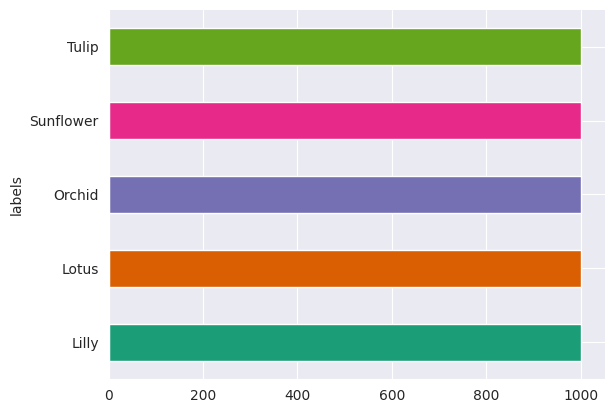

In [5]:
# @title labels

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('labels').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [6]:
train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123)


valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [7]:
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepath', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                       color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepath', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepath', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 4000 validated image filenames belonging to 5 classes.
Found 600 validated image filenames belonging to 5 classes.
Found 400 validated image filenames belonging to 5 classes.


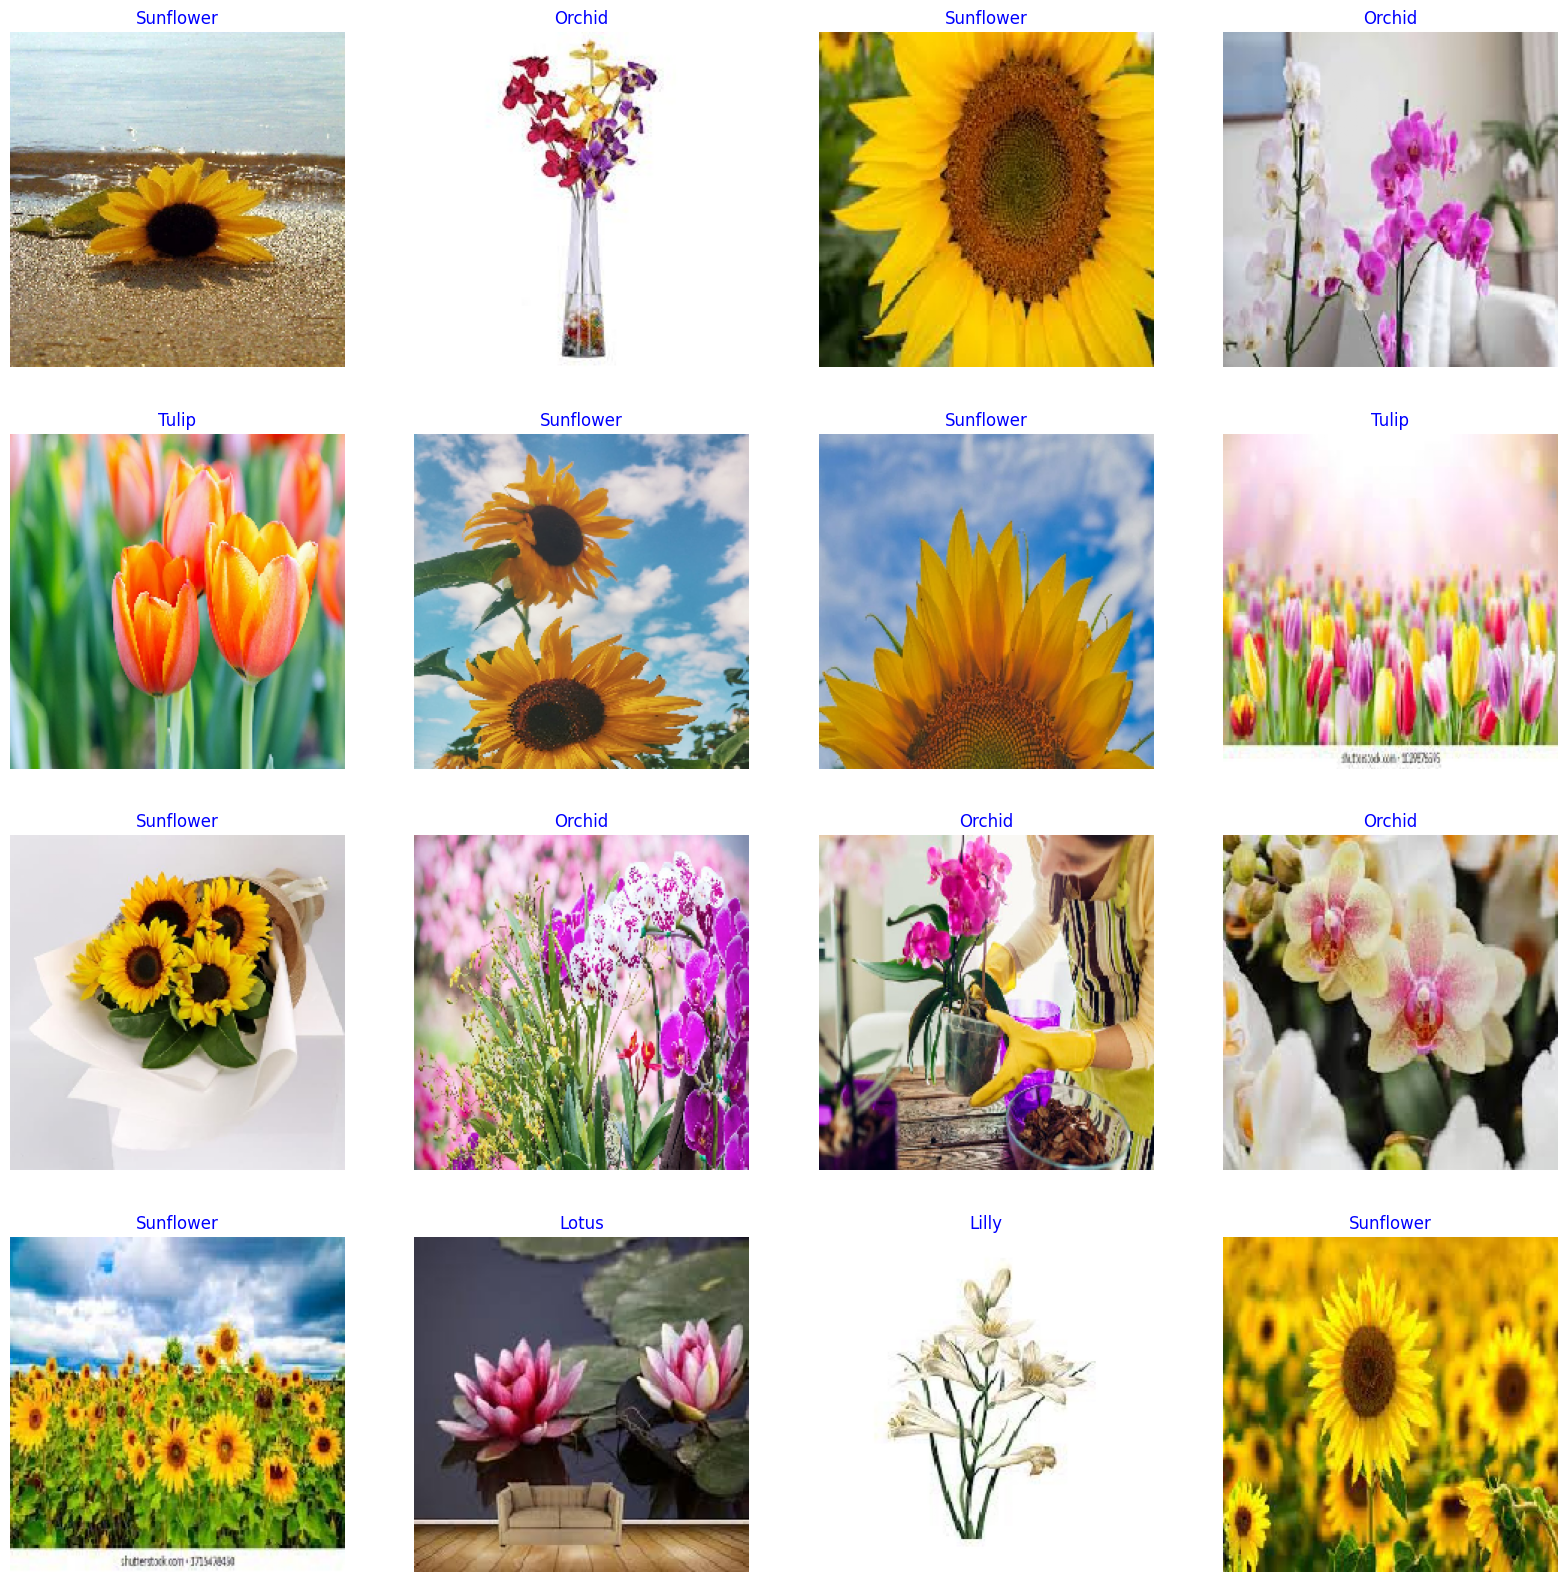

In [8]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

### Module Structure

In [9]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
# base_model.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

43941136/43941136 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1536)              6144      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                         

In [10]:
batch_size = 16   # set batch size for training
epochs = 10  # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen,
                    validation_steps= None, shuffle= False)

Epoch 1/10
250/250 [==============================] - 2010s 8s/step - loss: 7.1711 - accuracy: 0.7760 - val_loss: 5.5600 - val_accuracy: 0.9317
Epoch 2/10
250/250 [==============================] - 74s 296ms/step - loss: 4.5448 - accuracy: 0.9193 - val_loss: 3.5896 - val_accuracy: 0.9633
Epoch 3/10
250/250 [==============================] - 73s 292ms/step - loss: 2.9079 - accuracy: 0.9515 - val_loss: 2.2819 - val_accuracy: 0.9683
Epoch 4/10
250/250 [==============================] - 73s 294ms/step - loss: 1.8324 - accuracy: 0.9697 - val_loss: 1.4538 - val_accuracy: 0.9633
Epoch 5/10
250/250 [==============================] - 74s 297ms/step - loss: 1.1699 - accuracy: 0.9745 - val_loss: 0.8974 - val_accuracy: 0.9800
Epoch 6/10
250/250 [==============================] - 74s 294ms/step - loss: 0.7474 - accuracy: 0.9855 - val_loss: 0.6278 - val_accuracy: 0.9717
Epoch 7/10
250/250 [==============================] - 73s 291ms/step - loss: 0.5253 - accuracy: 0.9827 - val_loss: 0.4494 - val_acc

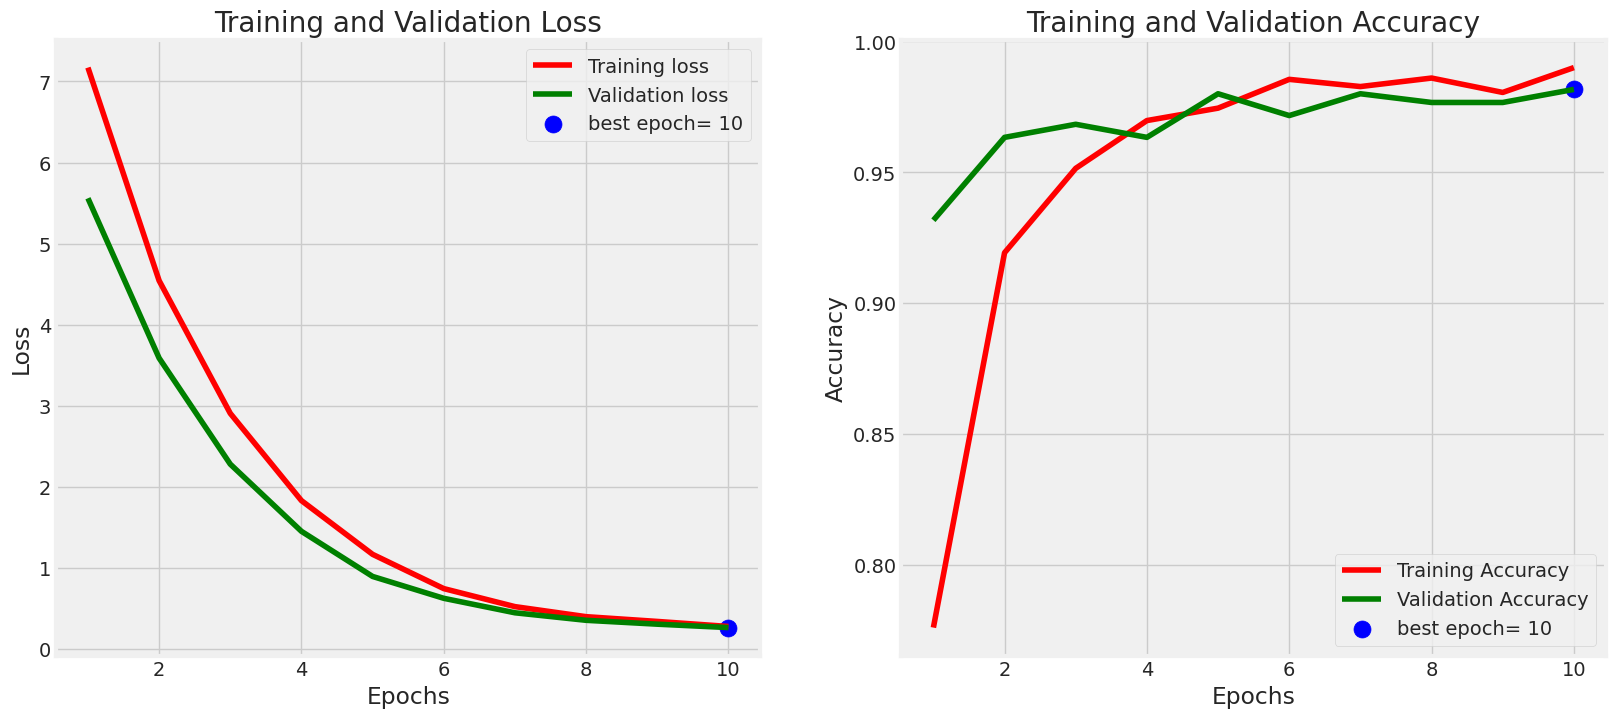

In [11]:

tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

## Evaluate Model

In [13]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range (1, ts_length + 1) if ts_length%n == 0 and ts_length/n <=80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose=1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose=1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

5/5 [==============================] - 1s 102ms/step - loss: 0.3163 - accuracy: 0.9750
Train Loss:  0.20366647839546204
Train Accuracy:  1.0
--------------------
Validation Loss:  0.24081702530384064
Validation Accuracy:  0.987500011920929
--------------------
Test Loss:  0.3162964880466461
Test Accuracy:  0.9750000238418579


## Get Predictions

In [14]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

## Confusion Metrics Classification Report

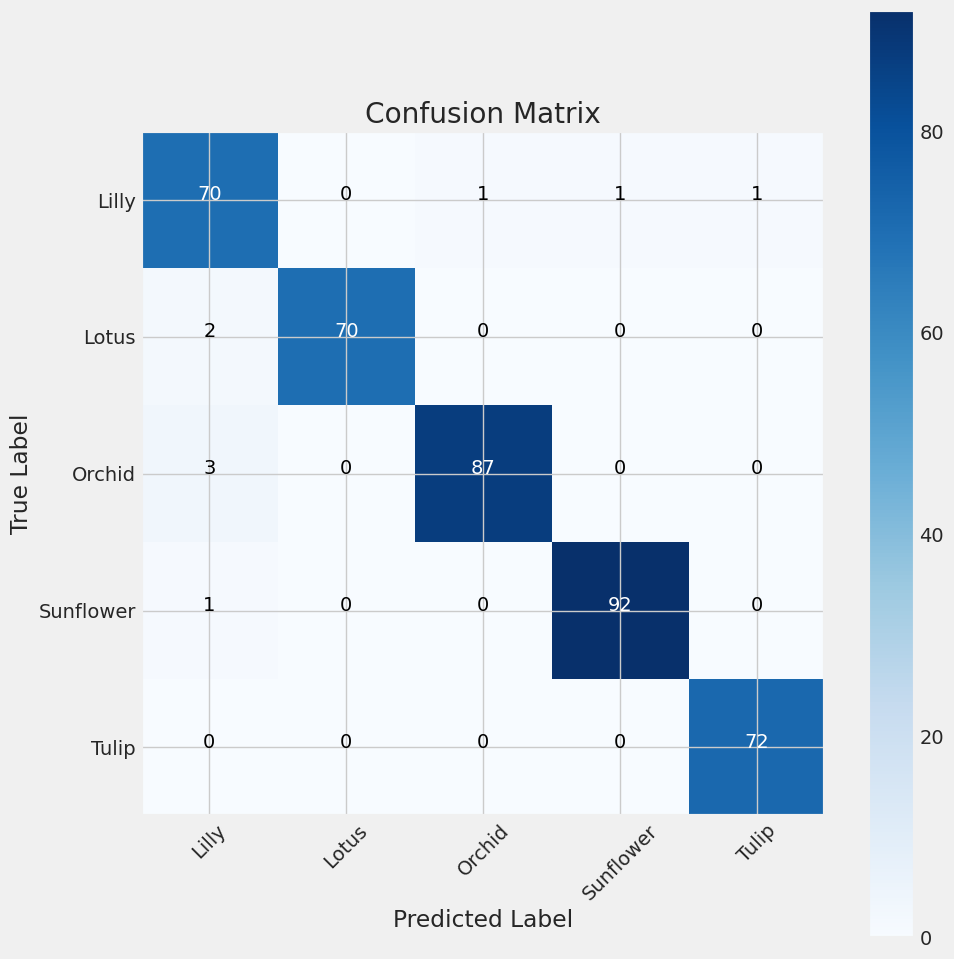

In [17]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())


cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [18]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

       Lilly       0.92      0.96      0.94        73
       Lotus       1.00      0.97      0.99        72
      Orchid       0.99      0.97      0.98        90
   Sunflower       0.99      0.99      0.99        93
       Tulip       0.99      1.00      0.99        72

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400



model.save('Flower Types.h5')

In [20]:
loaded_model = tf.keras.models.load_model('/content/Flower Types.h5')
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'Categorical_Crossentropy', metrics= ['accuracy'])

In [26]:
image_path = '/content/drive/MyDrive/frayer data/flower_images/Sunflower/004e98f65a.jpg'
image = Image.open(image_path)


img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)


predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 0s 36ms/step
Sunflower


In [27]:
predictions

array([[0.00222848, 0.00281532, 0.00227794, 0.9899458 , 0.00273243]],
      dtype=float32)